In [1]:
# Import the required packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast, os
import bambi as bmb
import pymc as pm
import arviz as az
import scipy.stats as stat
from collections import Counter
import itertools
# import hssm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
print(pm.__version__)

5.16.2


In [3]:
#Set up plotting themes
sns.set_context('talk')
sns.set_style('darkgrid')

# Function to clean the data files

#### For each data file this function does the following:
1. Drops irrelevant columns
2. Computes accuracies (accurate if all correct keys pressed on the first try)
3. Label Node types: Boundary vs non boundary
4. Label transition types: Cross cluster or within cluster
4. Label other relevant conditions like walk length, number of keypresses, etc. 

In [5]:
def clean_data(filename, root_dir = 'data'):
    # print(filename)
    # Handle errors. If there is an error, go to 'except' and return nothing.
    data = pd.read_csv(f'{root_dir}/{filename}')
    try:
        filtered_data = data[['participant', 'parent index', 'left child index', 'right child index', 'path_resp.keys', 'path_resp.rt', 'left distance', 'right distance']].dropna().reset_index(drop=True)
        filtered_data['parent cluster'] = 'B'
        filtered_data.loc[filtered_data['parent index'].isin([0, 1, 2, 3, 4]), 'parent cluster'] = 'A'
        
        filtered_data['left child cluster'] = 'B'
        filtered_data.loc[filtered_data['left child index'].isin([0, 1, 2, 3, 4]), 'left child cluster'] = 'A'
        
        filtered_data['right child cluster'] = 'B'
        filtered_data.loc[filtered_data['right child index'].isin([0, 1, 2, 3, 4]), 'right child cluster'] = 'A'
        
        filtered_data['left_option'] = 'across'
        filtered_data.loc[(filtered_data['parent cluster'] == filtered_data['left child cluster']), 'left_option'] = 'within'
        
        filtered_data['right_option'] = 'across'
        filtered_data.loc[(filtered_data['parent cluster'] == filtered_data['right child cluster']), 'right_option'] = 'within'
        
        filtered_data['left_right_option'] = filtered_data['left_option'] + '_' + filtered_data['right_option']
        
        filtered_data['left_right_distance'] = filtered_data['left distance'] - filtered_data['right distance']
        filtered_data['right_closer'] = 0
        filtered_data.loc[filtered_data['path_resp.keys'] == 'right', 'right_closer'] = 1
        filtered_data['walk_length'] = data['walk length'].unique()[0]
    except:
        return None

    #Return the dataframe with relevant columns
    return filtered_data
        # return filtered_data.loc[filtered_data['old or new'].isna()].reset_index(drop=True)
        


# Read the data files

In [6]:
#reads in all the NAMES of the data files from the 'data' folder. 
data_files = []
for f in os.listdir('data/'):
    if (f.endswith('csv')):
        data_files.append(f)

# Cleaning the data files into a single large dataframe

1. Label Trials, conditions, etc. 
2. Combine relevant columns of extracted data files 
3. Specify outliers and remove them


In [7]:
df_clean = pd.concat([clean_data(f) for f in data_files]).reset_index(drop = True)

# df_clean['reset'] = 'False'
# df_clean.loc[df_clean['trial'].values%(df_clean['walk_length'].values+1) == 0, 'reset'] = 'True'



# df_clean_rt_outlier = df_clean[np.abs(stat.zscore(df_clean['rt'], nan_policy='omit')) < 3]
# df_clean_rt_outlier['node_transition_type'] = df_clean_rt_outlier['node_type'] + ' ' + df_clean_rt_outlier['transition_type']

# df_clean_participant = df_clean_rt_outlier.groupby(['participant', 'graph identity', 'condition', 'test no']).mean(numeric_only = True).reset_index()

# # df_clean_rt_outlier['walk_length'] = df_clean_rt_outlier.walk_length.astype('str')
# # df_clean_rt_outlier['num_keypress'] = df_clean_rt_outlier['num_keypress'].astype(str)

# df_clean_participant

In [39]:
df_clean.loc[df_clean.walk_length == '1'].participant.unique().shape

(0,)

In [46]:
df_clean.loc[df_clean.walk_length == '1.0'].participant.unique().shape, df_clean.loc[df_clean.walk_length == '300.0'].participant.unique().shape

((18,), (27,))

In [4]:
df_clean = pd.read_csv('df_clean_dist.csv')

# Plot RTs


In [79]:
# df_clean_rt_outlier

# Plot Accuracies
1. Rotation
2. REcency


In [6]:
df_clean['walk_length'] = df_clean['walk_length'].astype(str)
df_clean['condition'] = 'unstructured'
df_clean.loc[df_clean.walk_length == '300.0', 'condition'] = 'structured'

In [7]:
df_clean['within chosen'] = 0
df_clean.loc[((df_clean['right_closer']) & (df_clean['right_option'] == 'within')), 'within chosen'] = 1
df_clean.loc[((1-df_clean['right_closer']) & (df_clean['right_option'] == 'across')), 'within chosen'] = 1
df_clean['right distance'] = df_clean['right distance'].values.astype(str)

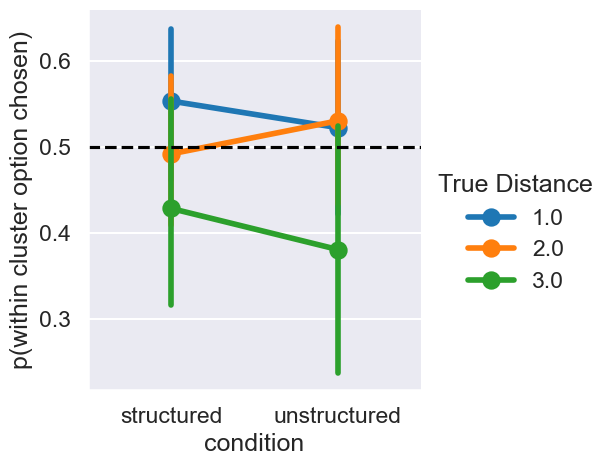

In [8]:
g = sns.catplot(y = 'within chosen',   x = 'condition', hue = 'right distance', 
           data = df_clean.loc[df_clean.left_right_distance == 0], kind = 'point', margin_titles=True, 
            hue_order= ['1.0', '2.0', '3.0'])
for i, ax in enumerate(g.axes.ravel()):
    ax.axhline(y = 0.5, ls = '--', color = 'black')
    # ax.set_title(f'')
    ax.set_xlabel('condition')

g.axes[0][0].set_ylabel('p(within cluster option chosen)')
g._legend.set_title('True Distance')
plt.savefig('figures/exp3_choice_results.png', dpi = 300, transparent = True)
# g.set_xticklabels(rotation=45)

In [9]:
# g = sns.catplot(y = 'path_resp.rt',   x = 'right distance', hue = 'condition', 
#            data = df_clean.loc[((df_clean.left_right_distance == 0) & (df_clean['within chosen']))], kind = 'point', margin_titles=True, 
#             order= ['1.0', '2.0', '3.0'], estimator='median')
# for i, ax in enumerate(g.axes.ravel()):
#     # ax.axhline(y = 0.5, ls = '--', color = 'black')
#     # ax.set_title(f'')
#     ax.set_xlabel('condition')
# g.axes[0][0].set_ylabel('p(within cluster option chosen)')
# # plt.savefig('figures/exp3_choice_results.png', dpi = 300, transparent = True)
# # g.set_xticklabels(rotation=45)

In [55]:
df_clean.loc[df_clean['right distance'].isin(['1.0','2.0' ,'3.0']), ['within chosen', 'right distance', 'condition']].groupby(['condition', 'right distance']).describe().iloc[:, [1, 2]].to_latex('tables/exp3_within_chosen_stats.txt', float_format="%.3f")

In [10]:
df_clean['within_chosen'] = df_clean['within chosen']
df_clean['true_distance'] = df_clean['right distance']

relevant_df = df_clean.loc[((df_clean['true_distance'].isin(['1.0','2.0' ,'3.0'])) & (df_clean['left_right_distance'] == 0)), ['within_chosen', 'true_distance', 'participant', 'condition']].reset_index(drop=True)
relevant_df

,within_chosen,true_distance,participant,condition
0,0,2.0,241032.0,structured
1,1,1.0,241032.0,structured
2,0,2.0,241032.0,structured
3,1,2.0,241032.0,structured
4,0,2.0,241032.0,structured
...,...,...,...,...
527,1,2.0,721147.0,unstructured
528,0,1.0,721147.0,unstructured
529,1,2.0,721147.0,unstructured
530,1,1.0,721147.0,unstructured


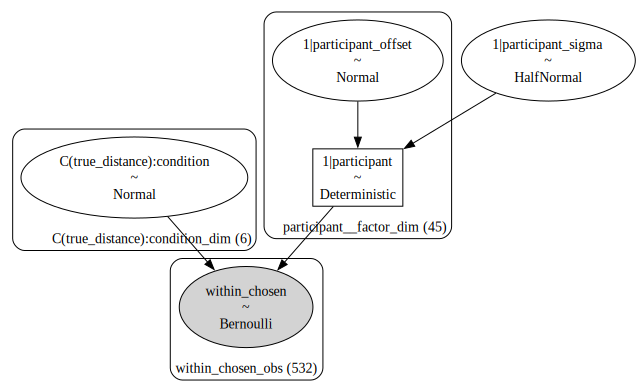

In [13]:
bmb_model = bmb.Model('within_chosen ~ 0 + C(true_distance):condition + (1|participant)', data = relevant_df, family='bernoulli')
bmb_model.build()
bmb_model.graph()

In [14]:
samples = bmb_model.fit()

Modeling the probability that within_chosen==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [C(true_distance):condition, 1|participant_sigma, 1|participant_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [18]:
az.summary(samples, var_names='~participant', filter_vars='like').iloc[:, :4].to_latex('tables/exp3_bayesmodel_stats.txt', float_format = "%0.3f")

In [22]:
extracted = az.extract(samples, var_names='~participant', filter_vars='like')
extracted

<xarray.DataArray 'C(true_distance):condition' (
                                                C(true_distance):condition_dim: 6,
                                                sample: 4000)> Size: 192kB
array([[ 0.66934702,  0.61516631, -0.15301845, ..., -0.24816769,
         0.49299472,  0.36819029],
       [ 0.01892781, -0.0014955 , -0.00334283, ..., -0.01761054,
         0.14461333,  0.06162098],
       [-0.31159834, -0.2816197 ,  0.17081142, ..., -0.3803395 ,
        -0.01881752, -0.0392884 ],
       [-0.01261147,  0.13459221, -0.04510001, ...,  0.32943447,
        -0.01182547, -0.01975188],
       [ 0.05233559, -0.16417337, -0.66575336, ..., -0.44367334,
        -0.34053764, -0.31319104],
       [-0.51768985, -0.47973376, -0.4701849 , ..., -0.61366426,
        -0.2361031 , -0.24737683]])
Coordinates:
  * C(true_distance):condition_dim  (C(true_distance):condition_dim) <U17 408B ...
  * sample                          (sample) object 32kB MultiIndex
  * chain                           (sample) int32 16kB 0 0 0 0 0 ... 3 3 3 3 3
  * draw                            (sample) int32 16kB 0 1 2 3 ... 997 998 999

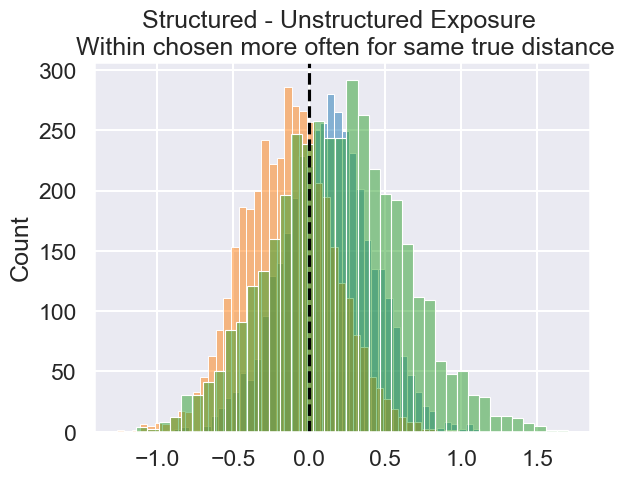

In [28]:
for dist in ['1.0', '2.0', '3.0']:
    g = sns.histplot(extracted.sel({"C(true_distance):condition_dim": f"{dist}, structured"}) - extracted.sel({"C(true_distance):condition_dim": f"{dist}, unstructured"}), alpha = 0.5)
g.axes.axvline(x = 0, ls = '--', color = 'black')
g.axes.set_title('Structured - Unstructured Exposure \n Within chosen more often for same true distance')
plt.savefig('figures/exp3_bayesmodel_results.png', dpi = 300, transparent = True)

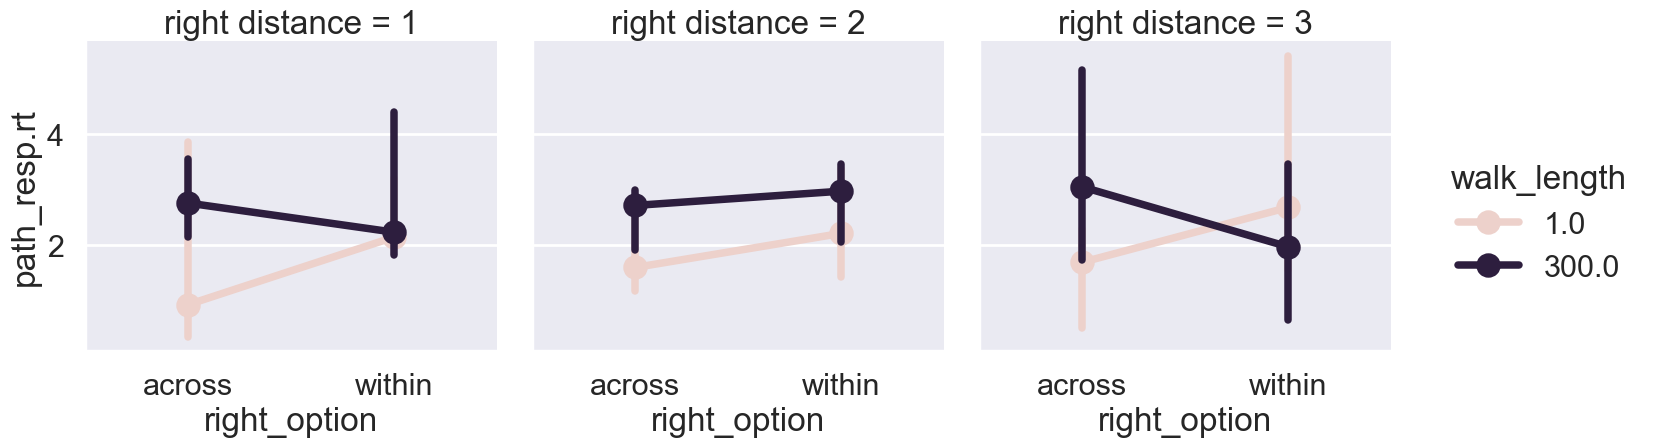

In [22]:
g = sns.catplot(y = 'path_resp.rt',   x = 'right_option', col = 'right distance', hue = 'walk_length', estimator='median',
           data = df_clean.loc[((df_clean.left_right_distance == 0) & (df_clean.right_closer == 1))], kind = 'point', margin_titles=True, 
            col_order= [1, 2, 3])
# for ax in g.axes.ravel():
#     ax.axhline(y = 0.5, ls = '--', color = 'black')


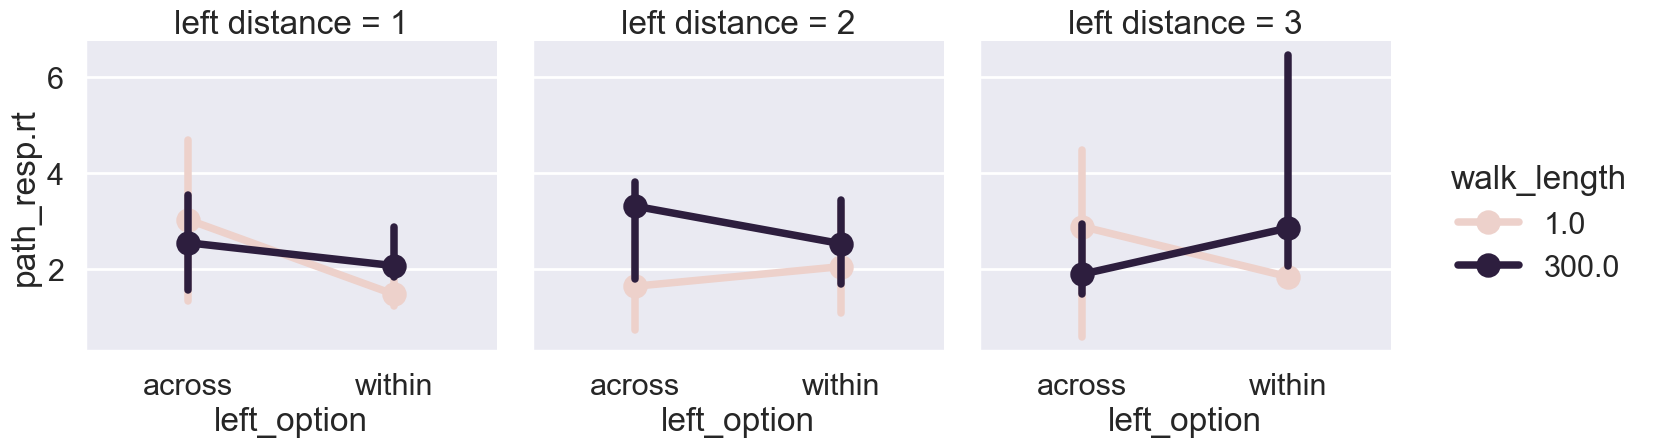

In [21]:
g = sns.catplot(y = 'path_resp.rt', x = 'left_option', col = 'left distance', hue = 'walk_length', estimator='median',
           data = df_clean.loc[((df_clean.left_right_distance == 0) & (df_clean.right_closer == 0))], kind = 'point', margin_titles=True, 
            col_order= [1, 2, 3], order = ['across', 'within'])


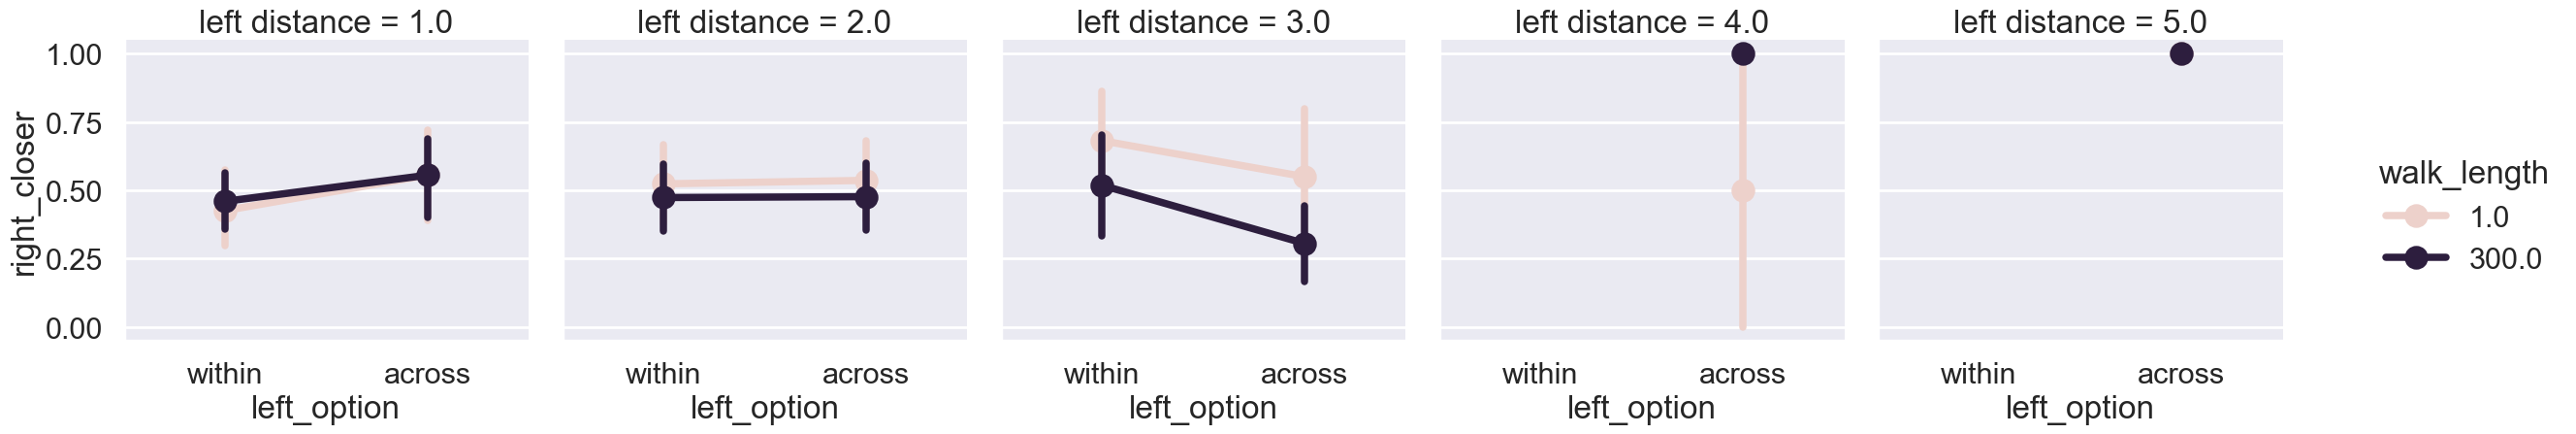

In [13]:
g = sns.catplot(y = 'right_closer',   x = 'left_option', col = 'left distance', hue = 'walk_length',
           data = df_clean.loc[df_clean.left_right_distance == 0], kind = 'point', margin_titles=True, 
            )
# g.set_xticklabels(rotation=45)